In [1]:
# code to generate yearly summaries of DUNE data volumes from input parameters
# rewritten from the version in the CDR - mainly by using maps of years instead of arrays to make it clearer what is in each year.
# HMS 2022-10-23


import os,sys,string,time,commentjson,datetime, math
from csv import reader
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DEBUG = False
DRAW = True
import numpy as np

from NumberUtils import dump
from NumberUtils import DrawTex
from NumberUtils import cumulateMap
from NumberUtils import DrawDet
from NumberUtils import DrawType
from NumberUtils import makeArray
from NumberUtils import ToCSV1
from NumberUtils import ToCSV2
from NumberUtils import SumOver1
from NumberUtils import SumOver2
from NumberUtils import TableTex
from NumberUtils import DrawTex

In [2]:
# read in a configfile
configfilename = "Parameters_2022-11-07-2040.json"

#if len(sys.argv) > 1:
#  configfile = sys.argv[1]

shortname = "report/"+configfilename.replace(".json","")
if os.path.exists(configfilename):
  with open(configfilename,'r') as f:
    config = commentjson.load(f)
else:
  print ("no config file",configfilename)
  sys.exit(0)

if not "Version" in config or config["Version"] < 5:
  print (" this code expects Version >= 2")
  sys.exit(1)

json_formatted_str = commentjson.dumps(config, indent=2)

In [3]:
# make a tex output file
texfilename = shortname + ".tex"
texfile = open(texfilename,'w')
tablefile = open("tables.tex",'w')
template = open("Header.tex",'r')
header = template.readlines()
for l in header:
    texfile.write(l)

In [4]:
MaxYear = config["MaxYear"]
config["filename"] = configfilename.replace("_","\_")
MinYear = config["MinYear"]
Detectors = config["Detectors"]
if DEBUG:
  Detectors = ["SP","SP2","DP"]
Years = np.array(config["Years"])
#if DEBUG:
#  Years = Years[0:7]
shortname = shortname.replace("2040","%d"%MaxYear)
print (Years, len(Years))
size = len(Years)

Units = config["Units"]
Formats = config["Formats"]

Detectors = config["Detectors"]

Cap = config["Cap"]

BaseMemory = config["Base-Memory"]

print (Detectors)

CombinedDetectors = config["CombinedDetectors"]

DetectorParameters = list(config["SP"].keys())

if "Comment" in DetectorParameters:
    DetectorParameters.remove("Comment")

TapeLifetimes = config["TapeLifetimes"]

DiskLifetimes = config["DiskLifetimes"]

TapeCopies = config["TapeCopies"]

DiskCopies = config["DiskCopies"]

# this is how far you go back each time you reprocess reco.
Reprocess = config["Reprocess"]

PerYear = config["PerYear"]

StorageTypes = list(TapeCopies.keys())

# plot config
DetColors=config["DetColors"]
DetLines = config["DetLines"]
TypeColors=config["TypeColors"]
TypeLines = config["TypeLines"]

PatternFraction = config["PatternFraction"]

SplitsYear = config["SplitsYear"]
SplitsEarly = config["SplitsEarly"]
SplitsLater = config["SplitsLater"]

Explain = config["Explain"]
Explain["filename"] = "Input configuration file"

[2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040] 23
['SP', 'SP2', 'DP', 'PDVD', 'HD', 'VD', 'ND']


In [5]:
for f in Explain.keys():
    
    texfile.write("{\\tt %s:} %s = {\\tt %s} \\\\\n"%(f,Explain[f], config[f]))

In [6]:
dofirst = ["Events","Test","Sim-Events"]
print ("Detector Parameters",DetectorParameters)
# read in the raw information

Inputs = {}
for det in Detectors:
  Inputs[det]={}
  for type in dofirst:
      Inputs[det][type]={}
      for year in Years:
          Inputs[det][type][year] = float(config[det][type][year-Years[0]])

# fill in other useful arrays
for det in Detectors:
  if DEBUG: print ("Events",det,Inputs[det]["Events"])
  #print ("see it", det,Inputs[det].keys())
  for key in DetectorParameters:
    #print(key,det)
    # skip the ones already done
    if key in dofirst:
      continue
    
    # sim has its own configuration
    # print ("this is the key",det,key)
    
    if key in ["Reco-CPU","Reco"]:  # if doing reco, do over previous events using memory
        Inputs[det][key] = cumulateMap(Years,Inputs[det]["Events"],Reprocess[det])
        for year in Years:
            Inputs[det][key][year] *= config[det][key]
        if key == "Reco-CPU":
            for year in Years:
                Inputs[det][key][year] *= (config[det]["Reco-Memory"]/BaseMemory)
        continue
        
    if key == "Raw":
        Inputs[det][key] ={}
        for year in Years:
            Inputs[det][key][year] = Inputs[det]["Events"][year]*config[det][key]
        continue
        
    if key in ["Sim","Sim-CPU"]:
        
        Inputs[det][key] ={}
        for year in Years:
            Inputs[det][key][year]=Inputs[det]["Sim-Events"][year]*config[det][key]
            if key == "Sim-CPU":
                Inputs[det][key][year]*=(config[det]["Sim-Memory"]/BaseMemory)
        continue
    if DEBUG: print ("other key",det,key)

for det in Inputs.keys():
    #print ("det",det,Inputs[det].keys())
    
    if "Sim-Memory" in Inputs[det]:
        Inputs[det].pop("Sim-Memory")
    if "Reco-Memory" in Inputs[det]:
        Inputs[det].pop("Reco-Memory")

Detector Parameters ['Raw', 'Reco-CPU', 'Sim-CPU', 'Reco', 'Sim', 'Reco-Memory', 'Sim-Memory', 'Events', 'Test', 'Sim-Events']


In [7]:
# make a data file which uses # of events to figure out how big samples are

if PerYear["Reco"]!=PerYear["Reco-CPU"]:
    print ("Data growth has to match reprocessing cycles/year")
    PerYear["Reco"] = PerYear["Reco-CPU"]
if PerYear["Sim"]!=PerYear["Sim-CPU"]:
    print ("Sim growth has to match reprocessing cycles/year")
    PerYear["Sim"] = PerYear["Sim-CPU"]

Data = {}
dump = open("dump.txt",'w')

    
#print (Inputs.keys())
fields = list(Inputs["ND"].keys())
#print ("fields",fields)
for dtype in fields:
  Data[dtype] = {}
  if "Memory" in dtype:
        continue
  for det in Inputs.keys():
    Data[dtype][det] = {}
    # this allows you to, say, do 2 passes of reco/year
    for year in Years:
        Data[dtype][det][year] = Inputs[det][dtype][year] * float(PerYear[dtype])
    # compensate for nominal units being millions and TB or singles and MB
    if Units[dtype] == "PB":
        for year in Years:
            Data[dtype][det][year] *= 0.001
    ds = "data %s %s %f\n"%(dtype,det,Data[dtype][det][2022])
    dump.write(ds)

In [8]:
# dtype = "Raw+Test"
# Data[dtype] = {}
# for det in Inputs.keys():
#     Data[dtype][det] = {}
    
#     for year in Years:
#         Data[dtype][det][year] =  Data["Raw"][det][year]+Data["Test"][det][year]
#     # compensate for nominal units being millions and TB or singles and MB



In [9]:
# impose a cap at Cap on things derived from raw data

dtype = "Raw"

Data["Raw"]["Total"] = {}
for year in Years:
        Data[dtype]["Total"][year] = 0.0
for det in Inputs.keys():
    for year in Years:
        Data[dtype]["Total"][year] +=  Data["Raw"][det][year]
        
dtypes = ["Raw","Reco-CPU"]
for dtype in dtypes:
    for det in Inputs.keys():
        #print (dtype,det,2035,1.0,Data[dtype][det][2035] )
        for year in Years:
            cap = Data["Raw"]["Total"][year]/Cap
           # print (dtype,det,year,cap,Data[dtype][det][year] )
            if cap > 1:
                Data[dtype][det][year] /=cap
        #print (dtype,det,2035,cap,Data[dtype][det][2035] )

# build analysis

Data["Analysis-CPU"]= {}

for det in Inputs.keys():
    Data["Analysis-CPU"][det] = {}
    for year in Years:
        Data["Analysis-CPU"][det][year] = (Data["Reco-CPU"][det][year]+Data["Sim-CPU"][det][year])*config["Analysis"]["Scale"]  
 
# then make the sums


dtypes = ["Raw","Reco-CPU","Sim-CPU","Analysis-CPU"]
for dtype in dtypes:
    Data[dtype]["Total"] ={}
    for year in Years:
        Data[dtype]["Total"][year] = 0.0
    for det in Inputs.keys():
        if dtype != "Analysis":
            for year in Years:
               Data[dtype]["Total"][year]+=  Data[dtype][det][year] 


             
    

PlotYears [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028]


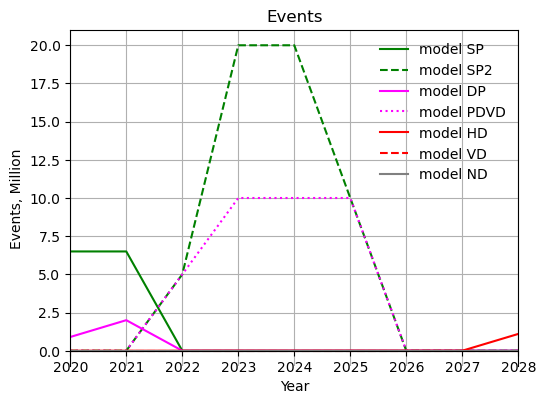

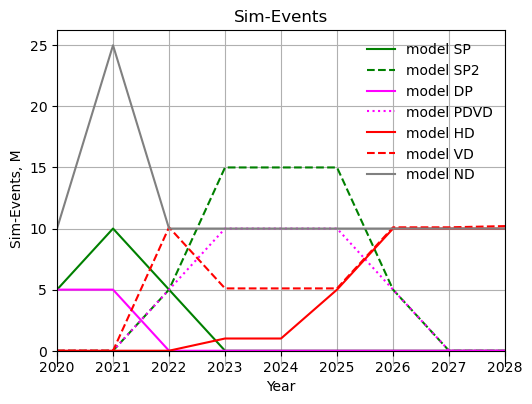

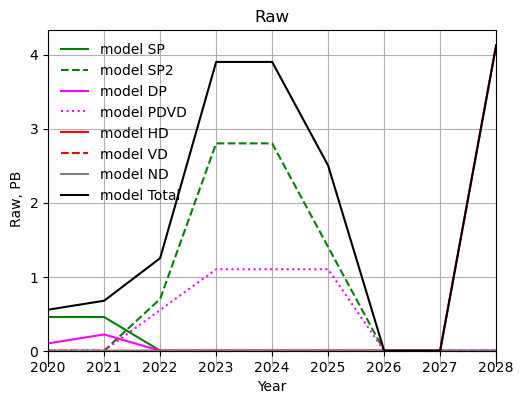

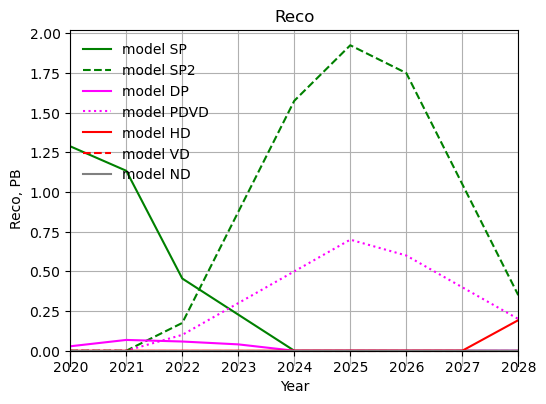

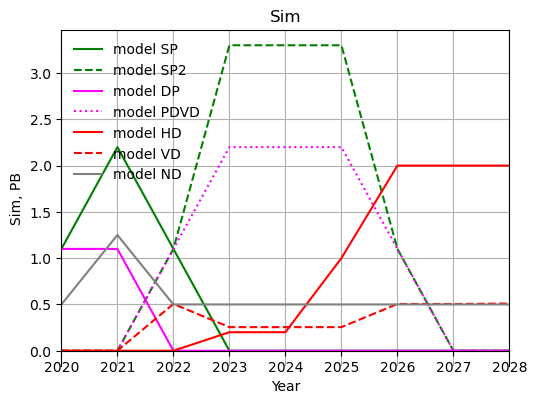

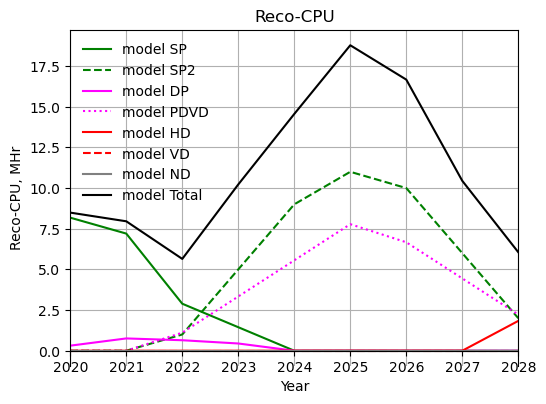

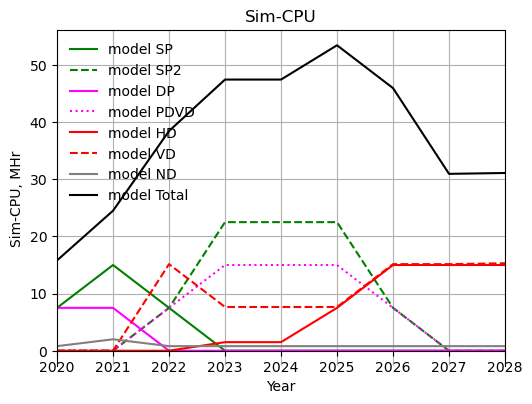

In [10]:
PlotYears = []
for i in range(MinYear,MaxYear+1):
    PlotYears.append(i)
#PlotYears = Years
print ("PlotYears",PlotYears)
# draw things
things = list(Inputs.keys())+["Total"]

if DRAW:
    for stuff in ["Events","Sim-Events","Raw","Reco","Sim","Reco-CPU","Sim-CPU"]:
        DrawDet(shortname,stuff,PlotYears,Data,things,Units,DetColors,DetLines)
    

# if DRAW:
#     DrawDet(shortname,"Events",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Reco-CPU",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim-CPU",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Raw",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Test",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim Events",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim",PlotYears,Data,Inputs.keys(),Units,DetColors,DetLines)
#     DrawDet(shortname,"Reco-CPU",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
#     DrawDet(shortname,"Sim-CPU",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
#     DrawDet(shortname,"Raw",PlotYears,Data,list(Inputs.keys())+["Total"],Units,DetColors,DetLines)
  
# for t in Data.keys():
#     print (t)
    
# Captions1 = {"Events":"Million of detector events per year projected",
# "Test":"PB of Test data projected",
# "Sim-Events":"Millions of simulated events per year projected",
# "Raw":"Raw data written per year in PB",
# "Reco-CPU":"CPU needs in core-years for data reconstruction. \
#              Slot weighted wall time takes into account memory use.  Assumes rereconstruction of older data.",
# "Sim-CPU":"CPU needs in core-years for simulation and reconstruction. \
#              Slot weighted wall time takes into account memory use."
# "Reco":
# Sim
# Total-CPU
# Cores
# HS06
# WALL
# Total
# Collab
# FNAL
# CERN

# for key in Data.keys():
#     ToCSV2("Table-"+key,key,PlotYears,Data,Units,Formats)
#     s = TableTex("Table-"+key,key+" values by detector.",key+"\n")ions
#     s2 = DrawTex(shortname,"Total-CPU.png","CPU time in Wall Hours/year. Squares are measured values for 2021.","TotalCPU")

#     print ("tex:",s)
#     texfile.write(s)

In [11]:
# merge far detector info

print ("Data keys",Data.keys())

for dtype in Data.keys():
    print ("Merge protodunes",dtype)
    det = "ProtoDUNEs" 
    Data[dtype][det] = {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["SP"][year] + Data[dtype]["DP"][year] + Data[dtype]["SP2"][year] + Data[dtype]["PDVD"][year]

    Data[dtype].pop("SP")
    Data[dtype].pop("SP2")
    Data[dtype].pop("DP")
    Data[dtype].pop("PDVD")
    


Data keys dict_keys(['Events', 'Test', 'Sim-Events', 'Raw', 'Reco-CPU', 'Sim-CPU', 'Reco', 'Sim', 'Analysis-CPU'])
Merge protodunes Events
Merge protodunes Test
Merge protodunes Sim-Events
Merge protodunes Raw
Merge protodunes Reco-CPU
Merge protodunes Sim-CPU
Merge protodunes Reco
Merge protodunes Sim
Merge protodunes Analysis-CPU


In [12]:
# merge far detector into "FDs
for dtype in Data.keys():
    det = "FDs"
    print ("merge FDS",dtype)
    Data[dtype][det] =  {}
    for year in Years:  
        Data[dtype][det][year] = Data[dtype]["HD"][year] + Data[dtype]["VD"][year]
    Data[dtype].pop("HD")
    Data[dtype].pop("VD")


merge FDS Events
merge FDS Test
merge FDS Sim-Events
merge FDS Raw
merge FDS Reco-CPU
merge FDS Sim-CPU
merge FDS Reco
merge FDS Sim
merge FDS Analysis-CPU


In [13]:
# make a total CPU category

Data["Total-CPU"]={}

for det in CombinedDetectors:
    Data["Total-CPU"][det] =  {}
    for year in Years:
        Data["Total-CPU"][det][year] = Data["Reco-CPU"][det][year] + Data["Sim-CPU"][det][year]
    #print(det,Data["Total-CPU"][det])

In [14]:
# do I want to remove CPU as a category? 
#del Data["Reco-CPU"]
#del Data["Sim-CPU"]

In [15]:
# make totals across categories. 

DataTypes = list(Data.keys())

for dt in DataTypes:
    Data[dt]["Total"] = {}
    for year in Years:
        Data[dt]["Total"][year]=0.0
    for k in Data[dt].keys():
        if k == "Total":
          continue  
        for year in Years:
            Data[dt]["Total"][year] += Data[dt][k][year]
    

In [16]:
# Data["Total-CPU"]["Analysis"]= {}
# for year in Years:
#     Data["Total-CPU"]["Analysis"][year]= 0.0
    
# for det in config["Analysis"]["Add"]:
#     for year in Years:
#     # scale allows you to change the scale of analysis relative to reconstruction and simulations
#           Data["Total-CPU"]["Analysis"][year]+= Data["Total-CPU"][det][year]*config["Analysis"]["Scale"]
    
# # and put it in the total

# for year in Years:
#     Data["Total-CPU"]["Total"][year] += Data["Total-CPU"]["Analysis"][year]



In [17]:
# and make a special data type for cores

Data["Cores"] = {}
Data["HS06"] = {}
#Data["WALL"] = {}
 
MHrsPerYear = 1000000./365./24.
for k in Data["Total-CPU"].keys():
    if "MARS" not in k :
        efficiency = config["Cores"]["Efficiency"]
    else:
        efficiency = 1

    scaleTo2020 = config["Cores"]["2020Units"]
    Data["Cores"][k]={}
    Data["HS06"][k]={}
#    Data["WALL"][k]={}
    for year in Years:
        Data["Cores"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020
        Data["HS06"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020*config["kHEPSPEC06PerCPU"]
#        Data["WALL"][k][year] = Data["Total-CPU"][k][year]*MHrsPerYear/efficiency/scaleTo2020


In [18]:
#ToCSV2("CoresbyDet","Cores",PlotYears,Data,Units,Formats)

In [19]:
# work out split between different institutions

Splits = {}
for f in SplitsEarly:
    Splits[f] = {}
    for t in SplitsEarly[f]:
        Splits[f][t] = {}
        for loc in SplitsEarly[f][t]: 
            Splits[f][t][loc] = {}
            #print (f,t,Splits[f][t],Splits[f][t][0])
    
            for y in Years:
                if y < SplitsYear:
                    Splits[f][t][loc][y]=SplitsEarly[f][t][loc]
                else:
                    Splits[f][t][loc][y]=SplitsLater[f][t][loc]

In [20]:
# now do some Cumulative-work.  Stuff stays on tape/disk for different amounts of time and we have multiple copies

Storage = {}
for k in StorageTypes:
    Storage[k] = {}
Storage["Total"] = {}
Storage["Collab"] = {}
Storage["FNAL"] = {}
Storage["CERN"] = {}
Storage["Total"]["Cumulative-Tape"] = {}
Storage["Total"]["Cumulative-Disk"] = {}
Storage["FNAL"]["Cumulative-Tape"] = {}
Storage["FNAL"]["Cumulative-Disk"] = {}
Storage["CERN"]["Cumulative-Tape"] = {}
Storage["CERN"]["Cumulative-Disk"] = {}
Storage["Collab"]["Cumulative-Tape"] = {}
Storage["Collab"]["Cumulative-Disk"] = {}


for year in Years:
    Storage["Total"]["Cumulative-Tape"][year] = 0.0
    Storage["Total"]["Cumulative-Disk"][year] = 0.0

for k in StorageTypes:
    Storage[k]["Tape"] = {}
    Storage[k]["Disk"] = {}
    for year in Years:
        Storage[k]["Tape"][year] = Data[k]["Total"][year]*TapeCopies[k]
        Storage[k]["Disk"][year] = Data[k]["Total"][year]*DiskCopies[k]
    Storage[k]["Cumulative-Tape"] = cumulateMap(Years,Storage[k]["Tape"],TapeLifetimes[k])
    Storage[k]["Cumulative-Disk"] = cumulateMap(Years,Storage[k]["Disk"],DiskLifetimes[k])
    
    for year in Years:
        Storage["Total"]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]
        Storage["Total"]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]
        
for loc in Splits["Disk"]["Raw"]:
    for year in Years:
        Storage[loc]["Cumulative-Disk"][year] = 0.0
        Storage[loc]["Cumulative-Tape"][year] = 0.0       
        for k in StorageTypes:
              Storage[loc]["Cumulative-Disk"][year] += Storage[k]["Cumulative-Disk"][year]*Splits["Disk"][k][loc][year]
              Storage[loc]["Cumulative-Tape"][year] += Storage[k]["Cumulative-Tape"][year]*Splits["Tape"][k][loc][year]


# cdisk = SumOver1("Cumulative-Disk",Data)
# print ("sum over",cdisk)

# for year in Years:
#         Data[loc]["Cumulative-Disk"][year] = 0.0
#         Data[loc]["Cumulative-Tape"][year] = 0.0       
#         for k in StorageTypes:
#               Data[loc]["Cumulative-Disk"][year] += Data[k]["Cumulative-Disk"][year] 
#               Data[loc]["Cumulative-Tape"][year] += Data[k]["Cumulative-Tape"][year] 


In [21]:
ToCSV1("Disk_by_location","Cumulative-Disk",PlotYears,Storage,Units,Formats)
ToCSV1("Tape_by_location","Cumulative-Tape",PlotYears,Storage,Units,Formats)
texfile.write("\\section{Disk and Tape needs by source and site}")
s = TableTex("Disk_by_location","Disk requests by location","Cumulative-Disk"+"\n")
texfile.write(s)
s = TableTex("Tape_by_location","Tape requests by location","Cumulative-Tape"+"\n")
texfile.write(s)




142

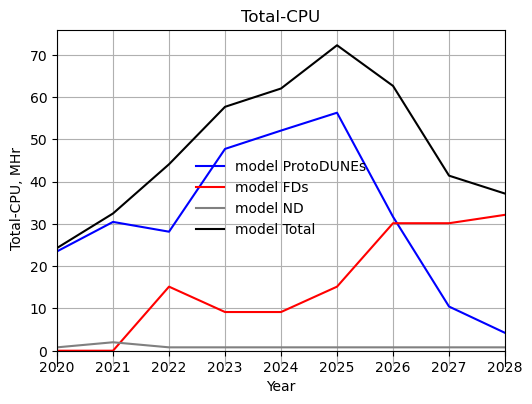

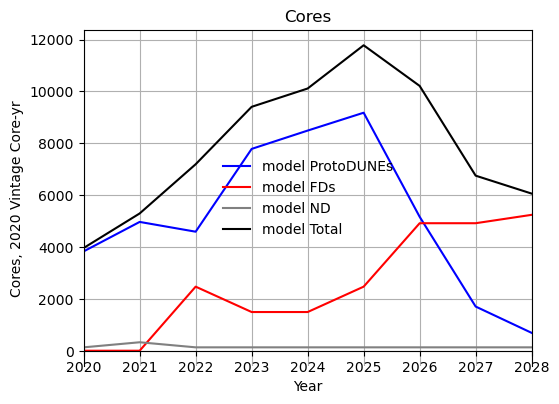

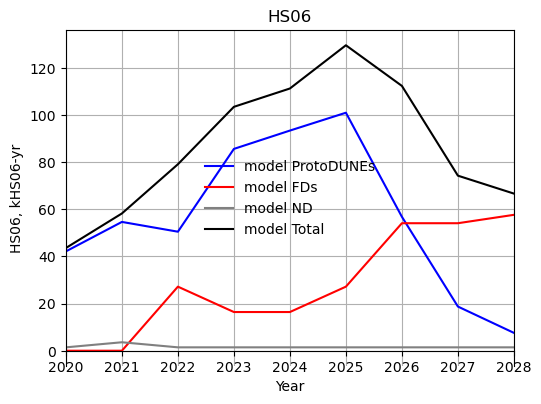

In [22]:
# now do some plots

Types = ["ProtoDUNEs","FDs","ND", "Analysis","Total"]

cpuactual = []
coreactual = []
wallactual = []



DrawDet(shortname,"Total-CPU",PlotYears,Data,Types,Units,DetColors,DetLines,cpuactual)
DrawDet(shortname,"Cores",PlotYears,Data,Types,Units,DetColors,DetLines,coreactual)
#DrawDet(shortname,"WALL",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)
DrawDet(shortname,"HS06",PlotYears,Data,Types,Units,DetColors,DetLines,wallactual)

for x in ["Total-CPU","Cores","HS06"]:
    ToCSV2("Table-"+x,x,PlotYears,Data,Units,Formats)

Events
Test
Sim-Events
Raw
Reco-CPU
Sim-CPU
Reco
Sim
Analysis-CPU
Total-CPU
Cores
HS06
{2018: 10.9, 2019: 19.9, 2020: 7.4, 2021: 8.5, 2022: 10.0, 2023: 30.0, 2024: 30.0, 2025: 20.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0}
{2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 1.1, 2029: 3.3000000000000003, 2030: 4.4, 2031: 4.4, 2032: 4.4, 2033: 8.8, 2034: 8.8, 2035: 8.8, 2036: 8.8, 2037: 8.8, 2038: 8.8, 2039: 8.8, 2040: 8.8}
{2018: 0.0, 2019: 0.0, 2020: 0.0, 2021: 0.0, 2022: 0.0, 2023: 0.0, 2024: 0.0, 2025: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 25.0, 2033: 25.0, 2034: 25.0, 2035: 25.0, 2036: 25.0, 2037: 25.0, 2038: 25.0, 2039: 25.0, 2040: 25.0}
Events dict_keys(['ND', 'ProtoDUNEs', 'FDs', 'Total'])


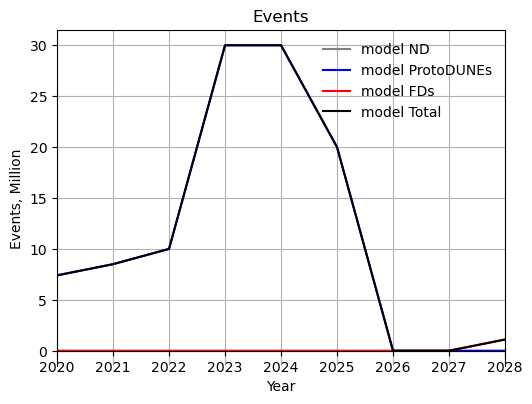

Test dict_keys(['ND', 'ProtoDUNEs', 'FDs', 'Total'])


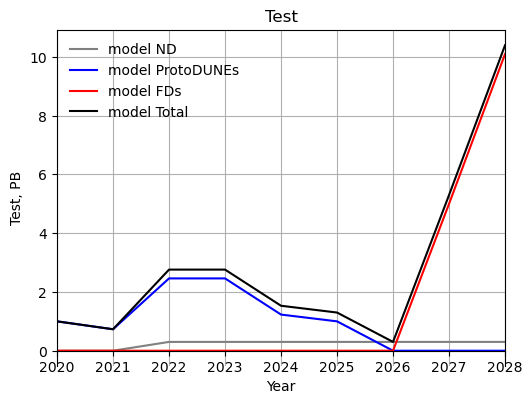

Sim-Events dict_keys(['ND', 'ProtoDUNEs', 'FDs', 'Total'])


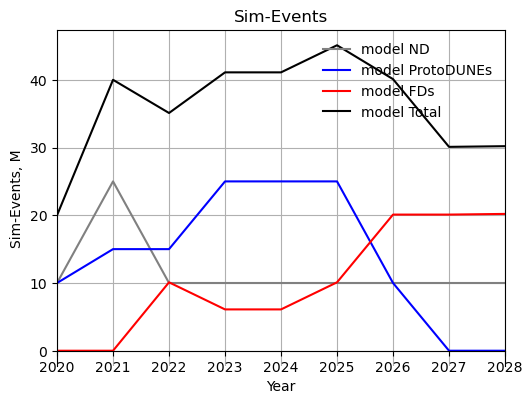

Raw dict_keys(['ND', 'Total', 'ProtoDUNEs', 'FDs'])


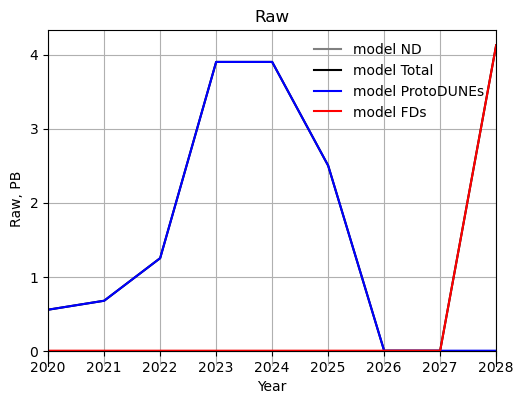

Reco-CPU dict_keys(['ND', 'Total', 'ProtoDUNEs', 'FDs'])


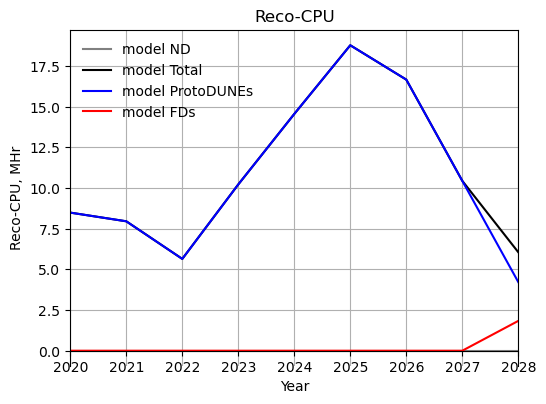

Sim-CPU dict_keys(['ND', 'Total', 'ProtoDUNEs', 'FDs'])


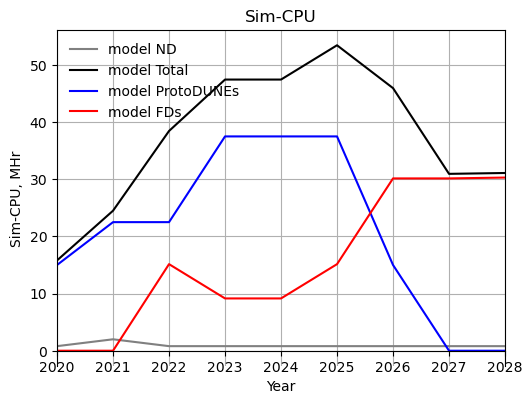

Reco dict_keys(['ND', 'ProtoDUNEs', 'FDs', 'Total'])


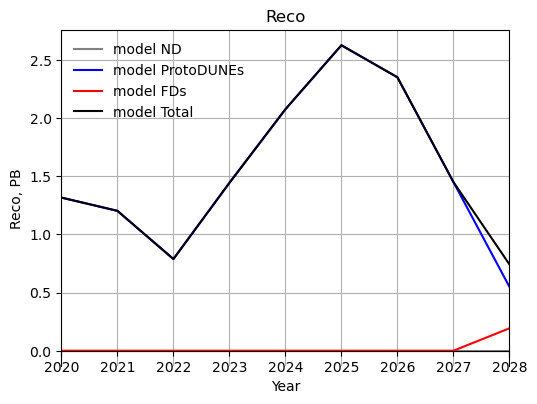

Sim dict_keys(['ND', 'ProtoDUNEs', 'FDs', 'Total'])


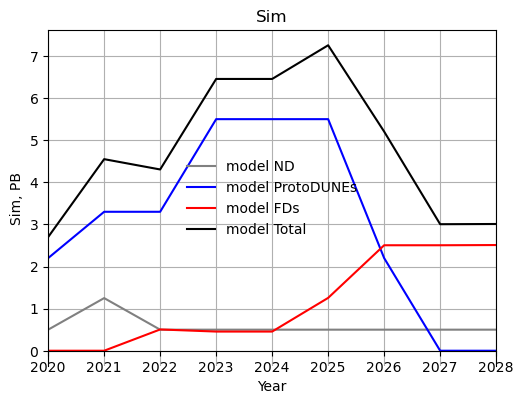

Analysis-CPU dict_keys(['ND', 'Total', 'ProtoDUNEs', 'FDs'])


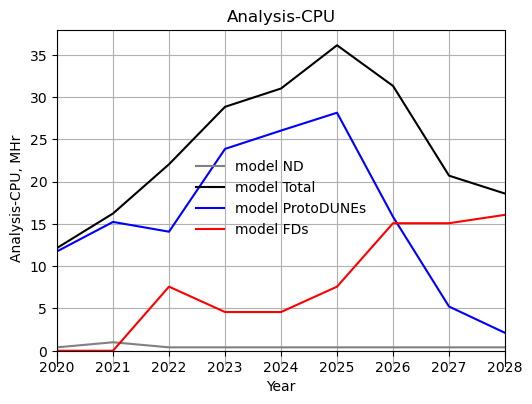

Total-CPU dict_keys(['ProtoDUNEs', 'FDs', 'ND', 'Total'])


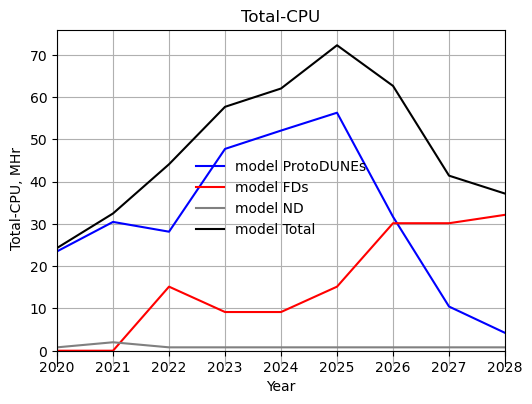

Cores dict_keys(['ProtoDUNEs', 'FDs', 'ND', 'Total'])


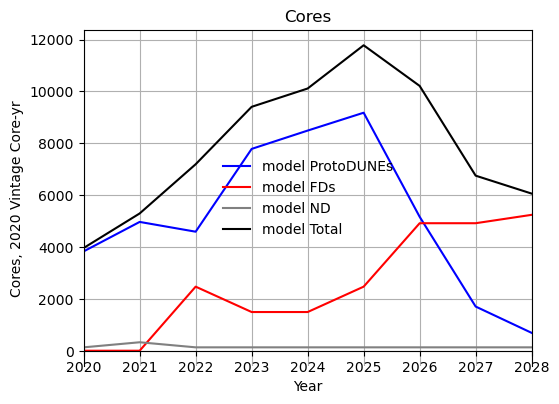

HS06 dict_keys(['ProtoDUNEs', 'FDs', 'ND', 'Total'])


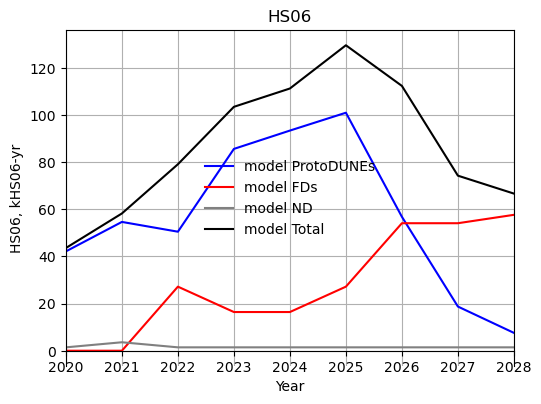

In [23]:
for t in Data.keys():
    print (t)
    
Captions2 = {"Events":"Million of detector events per year projected",
"Test":"PB of Test data projected",
"Sim-Events":"Millions of simulated events per year projected",
"Raw":"Raw data written per year in PB",
"Reco-CPU":"CPU needs in core-years for data reconstruction. \
             Slot weighted wall time takes into account memory use.  Assumes rereconstruction of older data.",
"Sim-CPU":"CPU needs in core-years for simulation and reconstruction. \
             Slot weighted wall time takes into account memory use.",
"Reco":"PB of reconstructed files/year",
"Sim":"PB of simulated files/year",
"Total-CPU":"Total CPU needs in core-years. Slot weighted wall time takes into account memory use.",
"Cores":"",
"HS06":"",
"WALL":"",
"Analysis-CPU":"Analysis CPU needs in core-years.",
            }
print (Data["Events"]["ProtoDUNEs"])
print (Data["Events"]["FDs"])
print (Data["Events"]["ND"])
for key in Data.keys():
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV2("Table-"+key,key,PlotYears,Data,Units,Formats)
    s = TableTex("Table-"+key,Captions2[key],key+"\n")
    print (key,Data[key].keys())
    DrawDet(shortname,key,PlotYears,Data,list(Data[key].keys()),Units,DetColors,DetLines)
    s2 = DrawTex(shortname,key+".png",Captions2[key],key)
    #texfile.write("\\pagebreak\n")
    texfile.write(s2)
    tablefile.write(s)
    

dict_keys(['Raw', 'Test', 'Reco', 'Sim', 'Total', 'Collab', 'FNAL', 'CERN'])
Cumulative-Tape \begin{table}[h]
\centering\csvautotabularright{Table-Cumulative-Tape.csv}\label{Cumulative-Tape
}
\caption{Cumulative Tape needs in PB. Includes data lifetimes}
\end{table}



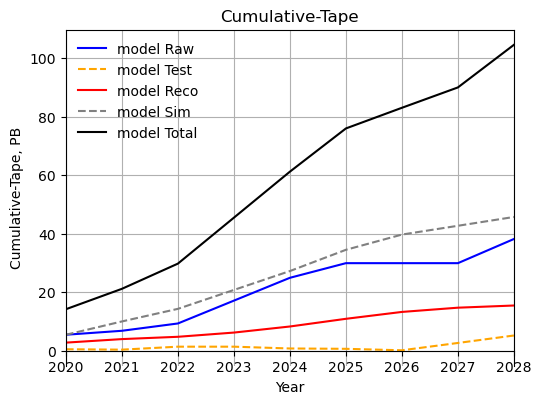

Cumulative-Disk \begin{table}[h]
\centering\csvautotabularright{Table-Cumulative-Disk.csv}\label{Cumulative-Disk
}
\caption{Cumulative Tape needs in PB. Includes data lifetimes}
\end{table}



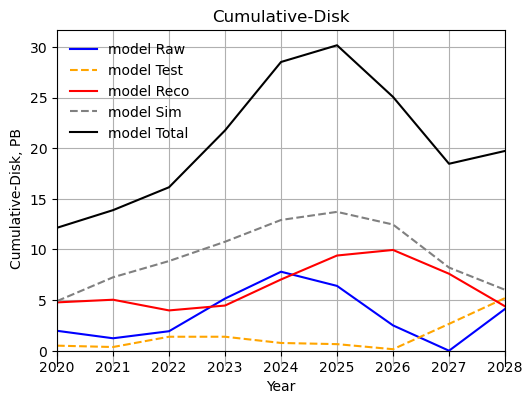

In [24]:
print (Storage.keys())
    
Captions1 = {"Cumulative-Tape":"Cumulative Tape needs in PB. Includes data lifetimes", 
             "Cumulative-Disk":"Cumulative Tape needs in PB. Includes data lifetimes"}
            

for key in ['Cumulative-Tape', 'Cumulative-Disk']:
    if not key in Units:
        print ("no units for key",key)
        continue
    ToCSV1("Table-"+key,key,PlotYears,Storage,Units,Formats)
    s = TableTex("Table-"+key,Captions1[key],key+"\n")
    print (key,s)
    DrawType(shortname,key,PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines)
    s2 = DrawTex(shortname,key+".png",Captions1[key],key)

    texfile.write(s2)
    texfile.write(s)

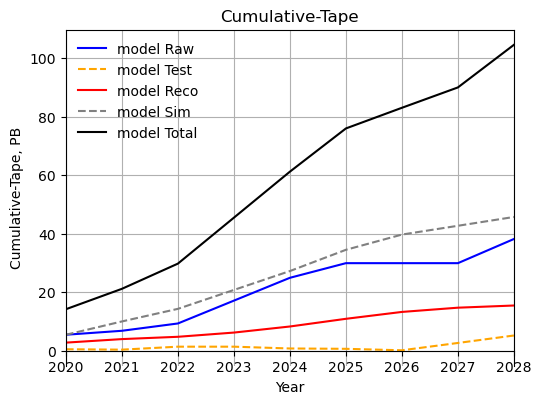

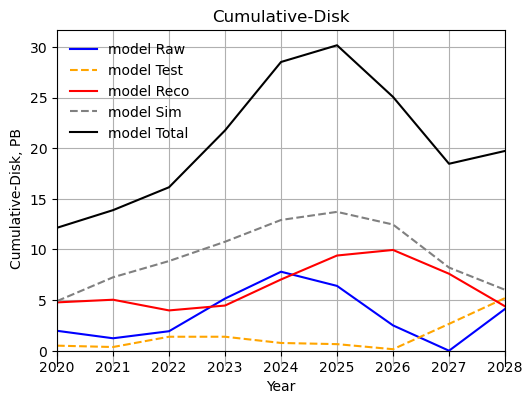

In [25]:

tapepoints = np.zeros(len(Years))
diskpoints = np.zeros(len(Years))

#DrawType(shortname,"Tape",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
DrawType(shortname,"Cumulative-Tape",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
DrawType(shortname,"Cumulative-Disk",PlotYears,Storage,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)
#DrawType(shortname,"Cumulative-Disk",Years,Data,StorageTypes+["Total"],Units,TypeColors,TypeLines,None,None)



In [26]:
tablefile.close()
texfile.write("\\input{tables.tex}\n")
texfile.write("\\end{document}\n")
texfile.close()

In [27]:
cmd='pdflatex %s'%texfilename
get_ipython().system('{cmd}')

This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./Parameters_2022-11-07-2040.tex
LaTeX2e <2017-04-15>
Babel <3.10> and hyphenation patterns for 84 language(s) loaded.
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2017/texmf-dist/tex/latex/base/size12.clo))
(/usr/local/texlive/2017/texmf-dist/tex/latex/csvsimple/csvsimple.sty
(/usr/local/texlive/2017/texmf-dist/tex/latex/pgf/utilities/pgfkeys.sty
(/usr/local/texlive/2017/texmf-dist/tex/generic/pgf/utilities/pgfkeys.code.tex
(/usr/local/texlive/2017/texmf-dist/tex/generic/pgf/utilities/pgfkeysfiltered.c
ode.tex))) (/usr/local/texlive/2017/texmf-dist/tex/latex/base/ifthen.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
(/usr/local/texlive/2017/texmf-dist/tex/latex/tools/shellesc.sty))
(/usr/local/texlive/2017/te